In [1]:
import pandas as pd
from calitp_data_analysis.tables import tbls
from siuba import _, collect, count, distinct, filter, select, show_query

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# QC `ntd_id_rtpa_crosswalk` against `dim_organizations`

As of 4/21/2025, `dim_orgs` now has an RTPA column. RTPA values were set from a previous `rtpa/mpo` column. The `ntd_id_rtpa_crosswalk`, derived from `mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_upt`,
was created by pulling all the agnecies in ntd and assigning a rtpa based on their city location.

## Tasks
- see if the ntd_id in the xwalk appear in dim_orgs and vise-versa.
    - are all ntd_id from xwalk in dim_orgs? NO
    - are all ntd_id from dim_orgs in xwalk? NO!
    
- do the ntd_id/rtpa pairs from xwalk match to dim_orgs
    - SCAG acounts for like 6 counties in Socal

- refactor analyses that use the old xwalk
    - remove old xwalk
    - replace with rtpa data from dim_orgs
    - make manual adjustments to SCAG agengies >> separate out to the socal CTCs (orange, imperial, san bernardino etc etc)


---
Findings
- there are some ntd_id that are unique to dim_orgs that are not in my xwalk
- vise-versa, there are some ntd_id that are unique to xwalk but are not in dim_orgs
- `Agency Status`: Designates agencies as active or inactive based on whether or not they submitted a report in the most recent report year.					


work-plan
- fill in the missing RTPA columns in dim_orgs via airtable
- what is the process of adding new orgs to dim_orgs? sounds like a lot of work (filling in all the columns)
- find out what agencies are unique to to crosswalk, that do not appear in dim_orgs. Assign ntd_ids and RTPA values to agencies we can fix.


## 5/9/2025: Observed Scenarios
Initial ntd_id to rtpa crosswalk was derived from `mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_upt`. We were later informed `dim_organizations` now contains rtpa data. However when compared using ntd_id, 36 agencies were unique to mart_ntd... and were not part of dim_organizations. agency name and ntd_id variables were analyed further

Options for each variable
- name
    - match
    - semi-match
    - different
    - none
- dim_org.ntd_id
    - match
    - different
    - none

Of the 12 possible combinations, 6 combinations were observed. The following scenarios were identified comparing the differences between the agency name and ntd_id in mart_ntd vs dim_orgs , and the resulting action or not.

CSV of all 38 agencies are in GCS: `gs://calitp-analytics-data/data-analyses/ntd/mart_ntd_orgs_compared_dim_orgs.csv`

In [2]:
# the final csv comparing the unique mart_ntd agencies to dim_org.
# found via mergeing the ntd id crosswalk to dim_orgs, then selecting the left-only unmerged rows to investigate futher.
mart_ntd_vs_dim_orgs = pd.read_csv("gs://calitp-analytics-data/data-analyses/ntd/mart_ntd_orgs_compared_dim_orgs.csv")

In [3]:
display(
    mart_ntd_vs_dim_orgs["ntd_id_2022 updated in airtable"].value_counts(dropna=False)
)

NaN     25
True    13
Name: ntd_id_2022 updated in airtable, dtype: int64

### 1. **name: match | dim_org.ntd_ID: none**
- Scenario where the mart_ntd agency name and the dim_org agency name are the same, or very obviously the same, but there was no ntd_ind in dim_org.
- example
    - "City of Benicia (Benicia Breeze) 90174" vs "City of Benicia n/a"
    - "City of Merced Transit System 90143" vs "City of Merced n/a "
- Solution: ntd_id from mart_ntd copied to ntd_id_2022 in airtable

In [4]:
mart_ntd_vs_dim_orgs[mart_ntd_vs_dim_orgs["Scenario"]=="name: match | dim_org.ntd_ID: none"]

,mart_ntd_funding_and_expenses...ntd_id,mart_ntd_funding_and_expenses...agency_name,last_report_year,city,agency_status,Scenario,dim_org.name equivilent,dim_org.ntd_id equivilent,result,ntd_id_2022 updated in airtable,Notes
2,90054,"San Diego Trolley, Inc. (MTS)",2006,San Diego,Inactive,name: match | dim_org.ntd_ID: none,"San Diego Trolley, Inc.",NaN,copied ntd_id to dim_org.ntd_id_2022,True,NaN
6,90143,City of Merced Transit System,1993,Merced,Inactive,name: match | dim_org.ntd_ID: none,City of Merced,NaN,copied ntd_id to dim_org.ntd_id_2022,True,NaN
12,90174,City of Benicia (Benicia Breeze),2011,Benicia,Inactive,name: match | dim_org.ntd_ID: none,City of Benicia,NaN,copied ntd_id to dim_org.ntd_id_2022,True,NaN
17,90187,"San Gabriel Transit, Inc. (SGT)",2000,Rosemead,Inactive,name: match | dim_org.ntd_ID: none,San Gabriel Transit Inc.,NaN,copied ntd_id to dim_org.ntd_id_2022,True,NaN
25,90231,City of Irvine (COI),2016,Irvine,Inactive,name: match | dim_org.ntd_ID: none,City of Irvine,NaN,copied ntd_id to dim_org.ntd_id_2022,True,NaN
36,90311,Stanislaus Council of Governments (StanCOG) - Mobility Programs,2023,Modesto,Active,name: match | dim_org.ntd_ID: none,Stanislaus Council of Governments,NaN,copied ntd_id to dim_org.ntd_id_2022,True,NaN


### 2. **name: match | dim_org.ntd_ID: different**
- When the mart_ntd and dim_org agency name are the same, but the dim_org ntd_id is different
- example
    - "Los Angeles County Metropolitan Transportation Authority (LACMTA) 90021" vs "Los Angeles County Metropolitan Transportation Authority 90154"
    - "Paratransit, Inc. CTSA 90224" vs "Paratransit Inc. 90223"
- no changes were made due to existing ntd_id. 
- guessing this will still cause some unmerged rows between mart_ntd and dim_orgs since there will be different ntd_id
- can the mart_ntd org names be added as an alias to in airtable?
 

In [5]:
mart_ntd_vs_dim_orgs[mart_ntd_vs_dim_orgs["Scenario"]=="name: match | dim_org.ntd_ID: different"]

,mart_ntd_funding_and_expenses...ntd_id,mart_ntd_funding_and_expenses...agency_name,last_report_year,city,agency_status,Scenario,dim_org.name equivilent,dim_org.ntd_id equivilent,result,ntd_id_2022 updated in airtable,Notes
0,90021,Los Angeles County Metropolitan Transportation Authority (LACMTA),1993,Los Angeles,Inactive,name: match | dim_org.ntd_ID: different,Los Angeles County Metropolitan Transportation Authority,90154,"no changes, dim_org.ntd_id_2022 already establised",NaN,put as alias on 90271?
24,90224,"Paratransit, Inc. CTSA",2013,Sacramento,Inactive,name: match | dim_org.ntd_ID: different,Paratransit Inc.,90223,"no changes, dim_org.ntd_id_2022 already establised",NaN,NaN
26,90269,"Los Angeles County - Department of Public Works, Transit Operations, Athens MB",2023,Alhambra,Active,name: match | dim_org.ntd_ID: different,"Los Angeles County (alias, LA DPW)?",90271,no changes. Add as alias?,NaN,NaN
27,90270,"Los Angeles County (LACDPW) - Department of Public Works, Transit Operations ? Avocado Heights",2023,Alhambra,Active,name: match | dim_org.ntd_ID: different,"Los Angeles County (alias, LA DPW)?",90271,no changes. Add as alias?,NaN,NaN
28,90272,"Los Angeles County (LACDPW) - Department of Public Works, Transit Operations ? East Valinda",2023,Alhambra,Active,name: match | dim_org.ntd_ID: different,"Los Angeles County (alias, LA DPW)?",90271,no changes. Add as alias?,NaN,NaN
29,90273,"Los Angeles County (LACDPW) - Department of Public Works, Transit Operations - Florence Firestone",2023,Alhambra,Active,name: match | dim_org.ntd_ID: different,"Los Angeles County (alias, LA DPW)?",90271,no changes. Add as alias?,NaN,NaN
30,90274,"Los Angeles County - Department of Public Works, Transit Operations, King Medical Center MB",2023,Alhambra,Active,name: match | dim_org.ntd_ID: different,"Los Angeles County (alias, LA DPW)?",90271,no changes. Add as alias?,NaN,NaN
31,90275,"Los Angeles County - Department of Public Works, Transit Operations, Lennox MB",2023,Alhambra,Active,name: match | dim_org.ntd_ID: different,"Los Angeles County (alias, LA DPW)?",90271,no changes. Add as alias?,NaN,NaN
32,90276,"Los Angeles County (LACDPW) - Department of Public Works, Transit Operations - South Whittier",2023,Alhambra,Active,name: match | dim_org.ntd_ID: different,"Los Angeles County (alias, LA DPW)?",90271,no changes. Add as alias?,NaN,NaN
33,90277,"Los Angeles County - Department of Public Works, Transit Operations, Whittier Et Al DR",2023,Alhambra,Active,name: match | dim_org.ntd_ID: different,"Los Angeles County (alias, LA DPW)?",90271,no changes. Add as alias?,NaN,NaN


### 3. **name: semi-match | dim_org.ntd_ID: none**
- When the mart_ntd and dim_org names are similar (but not exact), and there is no ntd_id in dim_org.
- example
    - "National City Transit (NCT) 90189" vs "City of National City n/a". 
    - "City of Vallejo Transportation Program (Vallejo Transit, Baylink) 90028" vs "City of Vallejo n/a". 
- Solution: ntd_id from mart_ntd copied to ntd_id_2022 in airtable
- felt pretty confident these were all the same agency, just different service/brand names

In [6]:
mart_ntd_vs_dim_orgs[mart_ntd_vs_dim_orgs["Scenario"]=="name: semi-match | dim_org.ntd_ID: none"]

,mart_ntd_funding_and_expenses...ntd_id,mart_ntd_funding_and_expenses...agency_name,last_report_year,city,agency_status,Scenario,dim_org.name equivilent,dim_org.ntd_id equivilent,result,ntd_id_2022 updated in airtable,Notes
1,90028,"City of Vallejo Transportation Program (Vallejo Transit, Baylink)",2012,Vallejo,Inactive,name: semi-match | dim_org.ntd_ID: none,City of Vallejo,recUwbn2HNnI2rpxY,copied ntd_id to dim_org.ntd_id_2022,True,"SolTrans services Vallejo now, need to talk this one out"
7,90150,City of Alameda Ferry Services,2010,Alameda,Inactive,name: semi-match | dim_org.ntd_ID: none,City of Alameda,NaN,copied ntd_id to dim_org.ntd_id_2022,True,NaN
9,90160,Outreach & Escort dba OUTREACH,2001,San Jose,Inactive,name: semi-match | dim_org.ntd_ID: none,OUTREACH,NaN,copied ntd_id to dim_org.ntd_id_2022,True,probably wrapped into BCAG
18,90188,County of San Diego Transit System (CTS),2003,San Diego,Inactive,name: semi-match | dim_org.ntd_ID: none,San Diego County,NaN,copied ntd_id to dim_org.ntd_id_2022,True,NaN
19,90189,National City Transit (NCT),2006,National City,Inactive,name: semi-match | dim_org.ntd_ID: none,City of National City,rec1S4pn6HGRfSekT,copied ntd_id to dim_org.ntd_id_2022,True,probably is City of Natnioal City. National city wiki said It was absored into MTS


### 4. **name: none | dim_org.ntd_ID: none**
- Where the mart_ntd name does not have a similar, or any equivilent name, in dim_org. thus, no dim_org ntd_id either.
- example
    - "ATC / Vancom 90170" vs "no name, no id"
    - "Laidlaw Transit Services 90178" vs "no name, no id"
    - "DAVE Transportation Services, Inc. 90158" vs"no name, no id"
- should these agencies be included in airtable?

In [7]:
mart_ntd_vs_dim_orgs[mart_ntd_vs_dim_orgs["Scenario"]=="name: none | dim_org.ntd_ID: none"]

,mart_ntd_funding_and_expenses...ntd_id,mart_ntd_funding_and_expenses...agency_name,last_report_year,city,agency_status,Scenario,dim_org.name equivilent,dim_org.ntd_id equivilent,result,ntd_id_2022 updated in airtable,Notes
8,90158,"DAVE Transportation Services, Inc.",2001,Sherman Oaks,Inactive,name: none | dim_org.ntd_ID: none,none,NaN,no changes. Add org to airtable?,NaN,NaN
11,90170,ATC / Vancom,2006,Oakland,Inactive,name: none | dim_org.ntd_ID: none,none,NaN,no changes. Add org to airtable?,NaN,NaN
13,90178,Laidlaw Transit Services,2001,El Monte,Inactive,name: none | dim_org.ntd_ID: none,none,NaN,no changes. Add org to airtable?,NaN,out of business
14,90179,Ryder/ATE,2001,West Covina,Inactive,name: none | dim_org.ntd_ID: none,none,NaN,no changes. Add org to airtable?,NaN,NaN
20,90190,"Laidlaw Transit Services, Inc.",2001,San Jose,Inactive,name: none | dim_org.ntd_ID: none,none,NaN,no changes. Add org to airtable?,NaN,out of business
37,99280,Reservation Transportation Authority,2015,none,NaN,name: none | dim_org.ntd_ID: none,NaN,NaN,no changes. Add org to airtable?,NaN,NaN


### 5. **name: different | dim_org.ntd_ID: different**
- When the mart_ntd and dim_org name have different, but slightly similar, names. with different ntd_id.
- example
    - "LACMTA - Small Operators (LACMTA) 90166" vs "90154 Los Angeles County Metropolitan Transportation Authority 90154"
    - "MTS Contract Services (MCS) 90185" vs probably, San Diego Metropolitan Transit System 90026
- no changes were made. less confident these names match
- need guidence

In [8]:
mart_ntd_vs_dim_orgs[mart_ntd_vs_dim_orgs["Scenario"]=="name: different | dim_org.ntd_ID: different"]

,mart_ntd_funding_and_expenses...ntd_id,mart_ntd_funding_and_expenses...agency_name,last_report_year,city,agency_status,Scenario,dim_org.name equivilent,dim_org.ntd_id equivilent,result,ntd_id_2022 updated in airtable,Notes
10,90166,LACMTA - Small Operators (LACMTA),2015,Los Angeles,Inactive,name: different | dim_org.ntd_ID: different,Los Angeles County Metropolitan Transportation Authority,90154,no changes. Add as alias?,NaN,put as alias on 90154?
15,90185,MTS Contract Services (MCS),2006,San Diego,Inactive,name: different | dim_org.ntd_ID: different,"probably, San Diego Metropolitan Transit System",90026,no changes. Add as alias?,NaN,NaN


### 6. **name: different | dim_org.ntd_ID: none**
- when mart_ntd and dim_org names have different, but slightly similar, names. but no ntd_id in dim_orgs
- example
    - "Chico Area Transit System City of Chico (CATS) 90128" vs "City of Chico n/a"
    - "Paso Robles Transit Services (PE) 90195" vs "City of Paso Robles n/a"
- some names were more confident than others.
- some ntd_ids were copied over. some were left alone.

In [9]:
mart_ntd_vs_dim_orgs[mart_ntd_vs_dim_orgs["Scenario"]=="name: different | dim_org.ntd_ID: none"]

,mart_ntd_funding_and_expenses...ntd_id,mart_ntd_funding_and_expenses...agency_name,last_report_year,city,agency_status,Scenario,dim_org.name equivilent,dim_org.ntd_id equivilent,result,ntd_id_2022 updated in airtable,Notes
3,90055,Monterey County RIDES,1996,Salinas,Inactive,name: different | dim_org.ntd_ID: none,Monterey County?,recPCdSwksmlKiK4k,no changes. Should ntd_id be copied over?,NaN,"There is Monterey County, but also ADA Paratransit RIDES in MST"
4,90077,Los Angeles County Transportation Commission / MTA,1993,Los Angeles,Inactive,name: different | dim_org.ntd_ID: none,Los Angeles County? (not CTC),NaN,no changes. Should ntd_id be copied over?,NaN,NaN
5,90127,Chico Area Transit System City of Chico (CATS),2005,Chico,Inactive,name: different | dim_org.ntd_ID: none,City of Chico,recNjaGALypWtjGar,copied ntd_id to dim_org.ntd_id_2022,True,NaN
16,90186,San Francisco Paratransit (ATC),2007,San Francisco,Inactive,name: different | dim_org.ntd_ID: none,"probably City and County of San Francisco, via the sfmta webite",NaN,no changes. Should ntd_id be copied over?,NaN,https://www.sfmta.com/getting-around/accessibility/paratransit
21,90193,Chula Vista Transit (CVT),2015,Chula Vista,Inactive,name: different | dim_org.ntd_ID: none,City of Chula Vista,recOT4QO6t6mRhUEu,copied ntd_id to dim_org.ntd_id_2022,True,? absorbed to MTS ?
22,90195,Paso Robles Transit Services (PE),2014,Paso Robles,Inactive,name: different | dim_org.ntd_ID: none,City of Paso Robles,recTsBhbc04OTbbe3,no changes. Should ntd_id be copied over?,NaN,"probably is City of Paso Robles, there is a ""Paso Express"" picture on the SLORTA website for Paso Robles Routes A & B services"
23,90212,Imperial Valley Transit (IVT),2010,El Centro,Inactive,name: different | dim_org.ntd_ID: none,Imperial County Transportation Commission,rec38PbjPbEy2Tvdu,no changes. Should ntd_id be copied over?,NaN,"IVT is listed as a service under ICTC, but IVT has its own website https://www.ivtransit.com/"


## Full Table

In [10]:
mart_ntd_vs_dim_orgs.sort_values(by="Scenario")

,mart_ntd_funding_and_expenses...ntd_id,mart_ntd_funding_and_expenses...agency_name,last_report_year,city,agency_status,Scenario,dim_org.name equivilent,dim_org.ntd_id equivilent,result,ntd_id_2022 updated in airtable,Notes
10,90166,LACMTA - Small Operators (LACMTA),2015,Los Angeles,Inactive,name: different | dim_org.ntd_ID: different,Los Angeles County Metropolitan Transportation Authority,90154,no changes. Add as alias?,NaN,put as alias on 90154?
15,90185,MTS Contract Services (MCS),2006,San Diego,Inactive,name: different | dim_org.ntd_ID: different,"probably, San Diego Metropolitan Transit System",90026,no changes. Add as alias?,NaN,NaN
23,90212,Imperial Valley Transit (IVT),2010,El Centro,Inactive,name: different | dim_org.ntd_ID: none,Imperial County Transportation Commission,rec38PbjPbEy2Tvdu,no changes. Should ntd_id be copied over?,NaN,"IVT is listed as a service under ICTC, but IVT has its own website https://www.ivtransit.com/"
3,90055,Monterey County RIDES,1996,Salinas,Inactive,name: different | dim_org.ntd_ID: none,Monterey County?,recPCdSwksmlKiK4k,no changes. Should ntd_id be copied over?,NaN,"There is Monterey County, but also ADA Paratransit RIDES in MST"
4,90077,Los Angeles County Transportation Commission / MTA,1993,Los Angeles,Inactive,name: different | dim_org.ntd_ID: none,Los Angeles County? (not CTC),NaN,no changes. Should ntd_id be copied over?,NaN,NaN
5,90127,Chico Area Transit System City of Chico (CATS),2005,Chico,Inactive,name: different | dim_org.ntd_ID: none,City of Chico,recNjaGALypWtjGar,copied ntd_id to dim_org.ntd_id_2022,True,NaN
22,90195,Paso Robles Transit Services (PE),2014,Paso Robles,Inactive,name: different | dim_org.ntd_ID: none,City of Paso Robles,recTsBhbc04OTbbe3,no changes. Should ntd_id be copied over?,NaN,"probably is City of Paso Robles, there is a ""Paso Express"" picture on the SLORTA website for Paso Robles Routes A & B services"
21,90193,Chula Vista Transit (CVT),2015,Chula Vista,Inactive,name: different | dim_org.ntd_ID: none,City of Chula Vista,recOT4QO6t6mRhUEu,copied ntd_id to dim_org.ntd_id_2022,True,? absorbed to MTS ?
16,90186,San Francisco Paratransit (ATC),2007,San Francisco,Inactive,name: different | dim_org.ntd_ID: none,"probably City and County of San Francisco, via the sfmta webite",NaN,no changes. Should ntd_id be copied over?,NaN,https://www.sfmta.com/getting-around/accessibility/paratransit
0,90021,Los Angeles County Metropolitan Transportation Authority (LACMTA),1993,Los Angeles,Inactive,name: match | dim_org.ntd_ID: different,Los Angeles County Metropolitan Transportation Authority,90154,"no changes, dim_org.ntd_id_2022 already establised",NaN,put as alias on 90271?


### What are the agencies with last report year >2018 that still need to be resolved?

In [59]:
mart_ntd_vs_dim_orgs[
    (mart_ntd_vs_dim_orgs["last_report_year"]>2018) &
    (mart_ntd_vs_dim_orgs["ntd_id_2022 updated in airtable"].isna())
][[
    "mart_ntd_funding_and_expenses...ntd_id",
    "mart_ntd_funding_and_expenses...agency_name",
]]

# just LA County

,mart_ntd_funding_and_expenses...ntd_id,mart_ntd_funding_and_expenses...agency_name
26,90269,"Los Angeles County - Department of Public Works, Transit Operations, Athens MB"
27,90270,"Los Angeles County (LACDPW) - Department of Public Works, Transit Operations ? Avocado Heights"
28,90272,"Los Angeles County (LACDPW) - Department of Public Works, Transit Operations ? East Valinda"
29,90273,"Los Angeles County (LACDPW) - Department of Public Works, Transit Operations - Florence Firestone"
30,90274,"Los Angeles County - Department of Public Works, Transit Operations, King Medical Center MB"
31,90275,"Los Angeles County - Department of Public Works, Transit Operations, Lennox MB"
32,90276,"Los Angeles County (LACDPW) - Department of Public Works, Transit Operations - South Whittier"
33,90277,"Los Angeles County - Department of Public Works, Transit Operations, Whittier Et Al DR"
34,90278,"Los Angeles County - Department of Public Works, Transit Operations, Willowbrook MB"
35,90279,"Los Angeles County - Department of Public Works, Transit Operations, Willowbrook et. al. DR"


Ran these ntd_id through `mart_ntd.dim_annual_agency_information` to see if they exist, results returned `Los Angeles County` for agency_name.

Meaning 2 things:
1. these ntd_id do not exist in dim_orgs
2. these ntd_ids do exist in dim_annual_agency_information, and looks like they already fixed themselves?

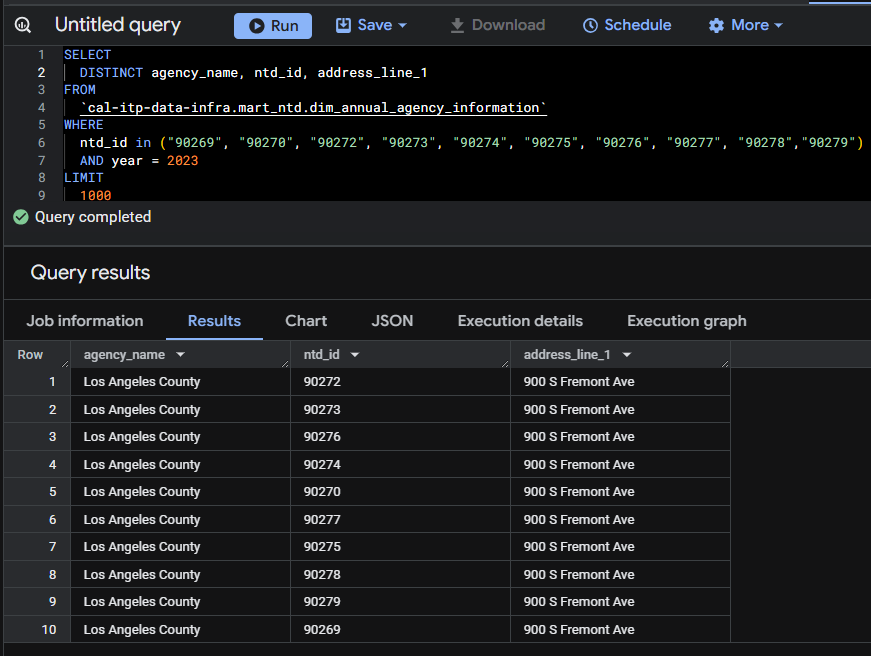



## In summary

is everything accounted for now?

If we ensure future NTD analyses are from 2018 to present, then the ntd_id/RTPA data in dim_orgs should be good to use. 

With the exception of the multiple `Los Angeles County` ntd_id. However, I believe this can be easily accounted for.


## Next Steps
Test replacing the initial ntd_id to RTPA xwalk with the updated dim_organizations.

Affected analyses:
- Annual NTD Ridership Report
- New Transit Performance Metrics
- Monthly NTD Ridership Report

In each analyses, find the cell that merges data. then replace the xwalk with dim_orgs.

In [ ]:
# Test: Annual NTD Ridership Report

In [60]:
# Test: New Transit Performance Metrics

In [ ]:
# Test: Monthly NTD Ridership Report


---
## Explore work

In [11]:
xwalk = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/ntd/ntd_id_rtpa_crosswalk_all_reporter_types.parquet"
)

In [12]:
# crosswalk initially dirived from this mart_ntd_funding_and_expense table
mart_ntd = (
    tbls.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_upt()
    >> filter(
        _.state =="CA",
        _.ntd_id.notna()
    )
    >> distinct(
        _.agency_name,
        _.ntd_id,
        _.last_report_year,
        _.agency_status,
        _.city 
    )
    
    >> collect()
)

mart_ntd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   agency_name       254 non-null    object
 1   ntd_id            254 non-null    object
 2   last_report_year  254 non-null    int64 
 3   agency_status     254 non-null    object
 4   city              253 non-null    object
dtypes: int64(1), object(4)
memory usage: 10.1+ KB


In [13]:
dim_orgs = (
    tbls.mart_transit_database.dim_organizations()
    >> filter(
        _._is_current == True,
        # _.public_currently_operating == True,
        _.ntd_id_2022 != "",
    )
    >> select(
        _.name,
        _.ntd_id_2022,
        _.rtpa_name,
        _.key,
        # _.alias # alias is a list that is messing up merges down the line
    )
    >> collect()
)

dim_orgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         245 non-null    object
 1   ntd_id_2022  245 non-null    object
 2   rtpa_name    244 non-null    object
 3   key          245 non-null    object
dtypes: object(4)
memory usage: 7.8+ KB


In [14]:
currently_operating = (
    tbls.mart_transit_database.dim_organizations()
    >> filter(
        _._is_current == True, _.public_currently_operating == True, _.ntd_id_2022 != ""
    )
    >> select(
        _.name,
        _.ntd_id_2022,
        _.rtpa_name,
        _.key,
        # _.alias
    )
    >> collect()
)

currently_operating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         183 non-null    object
 1   ntd_id_2022  183 non-null    object
 2   rtpa_name    183 non-null    object
 3   key          183 non-null    object
dtypes: object(4)
memory usage: 5.8+ KB


In [15]:
currently_operating[currently_operating["ntd_id_2022"].isna()]

,name,ntd_id_2022,rtpa_name,key


In [16]:
# need to get county info?
county_bridge = (
    tbls.mart_transit_database.bridge_organizations_x_headquarters_county_geography()
    >> filter(
        _._is_current == True,
    )
    >> select(
        _.organization_key,
        _.organization_name,
        _.county_geography_name,
        _.county_geography_key,
    )
    >> collect()
)

county_bridge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   organization_key       1294 non-null   object
 1   organization_name      1294 non-null   object
 2   county_geography_name  1294 non-null   object
 3   county_geography_key   1294 non-null   object
dtypes: object(4)
memory usage: 40.6+ KB


In [17]:
dim_org_county = dim_orgs.merge(
    county_bridge, how="left", left_on="key", right_on="organization_key"
)

display(
    dim_org_county.info(),
    # dim_org_county.head()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 0 to 244
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   245 non-null    object
 1   ntd_id_2022            245 non-null    object
 2   rtpa_name              244 non-null    object
 3   key                    245 non-null    object
 4   organization_key       245 non-null    object
 5   organization_name      245 non-null    object
 6   county_geography_name  245 non-null    object
 7   county_geography_key   245 non-null    object
dtypes: object(8)
memory usage: 17.2+ KB


None

In [18]:
dim_org_county_2 = currently_operating.merge(
    county_bridge, how="left", left_on="key", right_on="organization_key"
)

display(
    dim_org_county_2.info(),
    # dim_org_county.head()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 182
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   183 non-null    object
 1   ntd_id_2022            183 non-null    object
 2   rtpa_name              183 non-null    object
 3   key                    183 non-null    object
 4   organization_key       183 non-null    object
 5   organization_name      183 non-null    object
 6   county_geography_name  183 non-null    object
 7   county_geography_key   183 non-null    object
dtypes: object(8)
memory usage: 12.9+ KB


None

## What is the differences in NTD id between dim_org_county and dim_org_county_2?


In [19]:
id_check = dim_org_county.merge(dim_org_county_2, how="outer", indicator=True)

In [20]:
display(
    id_check["_merge"].value_counts(),
)

both          183
left_only      62
right_only      0
Name: _merge, dtype: int64

### Decision

It is possible for agencies to switch between currently operating and not operating. Therefore, RTPA values should be assigned to agencies regardless of operating status.

## What are the unique pairs of RTPA names and geography names?

In [21]:
rtpa_county = (
    dim_org_county[dim_org_county["rtpa_name"].notna()][
        ["county_geography_name", "rtpa_name"]
    ]
    .drop_duplicates()
    .sort_values(by="rtpa_name")
)
rtpa_county[rtpa_county["county_geography_name"].str.contains("Plumas")]

,county_geography_name,rtpa_name
60,Plumas,Plumas County Transportation Commission


## Create dictionary of counties names : RTPA name

In [22]:
county_rtpa_dict = rtpa_county.set_index("county_geography_name")["rtpa_name"].to_dict()
county_rtpa_dict.update(
    {
        "Plumas": "Plumas County Transportation Commission",
        "Sierra": "Sierra County Transportation Commission",
        # "Imperial":"Imperial County Transportation Commission", NO! Imperial is under SCAG
        # "Los Angeles":"Los Angeles County Metropolitan Transportation Authority", NO! LA is SCAG
    }
)
county_rtpa_dict["Imperial"]

'Southern California Association of Governments'

## What are the Agencies with missing RTPA names, but have a county name?

In [23]:
dim_org_county[
    (dim_org_county["rtpa_name"].isna())
    & (dim_org_county["county_geography_name"].isna())
].drop_duplicates()

# added rtpa names in airtable

,name,ntd_id_2022,rtpa_name,key,organization_key,organization_name,county_geography_name,county_geography_key


In [24]:
no_rtpa = dim_org_county[
    (dim_org_county["rtpa_name"].isna())
    & (dim_org_county["county_geography_name"].notna())
].drop_duplicates()

len(no_rtpa)

1

## !!THESE ORGS NEED RTPAs IN dim_orgs!!

In [25]:
no_rtpa["update_dim_org_rtpa_to"] = no_rtpa["county_geography_name"].map(
    county_rtpa_dict
)

In [26]:
display(
    no_rtpa.info(),
    no_rtpa[
        [
            "name",
            "ntd_id_2022",
            "rtpa_name",
            # "alias",
            "county_geography_name",
            "update_dim_org_rtpa_to",
        ]
    ].sort_values(by="county_geography_name"),
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 4 to 4
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   name                    1 non-null      object
 1   ntd_id_2022             1 non-null      object
 2   rtpa_name               0 non-null      object
 3   key                     1 non-null      object
 4   organization_key        1 non-null      object
 5   organization_name       1 non-null      object
 6   county_geography_name   1 non-null      object
 7   county_geography_key    1 non-null      object
 8   update_dim_org_rtpa_to  1 non-null      object
dtypes: object(9)
memory usage: 80.0+ bytes


None

,name,ntd_id_2022,rtpa_name,county_geography_name,update_dim_org_rtpa_to
4,California Department of Transportation,9R02,None,Sacramento,Sacramento Area Council of Governments


4/28/2025 - added rtpa to those agencies. 
4/28/2025 - changes took affect.


## What are the unique RTPA in dim_orgs
- are any of the SOCAL CTCs in there?


There are some County Transportation Commission in the RTPA list
- Ventura County Transportation Commission

Could not find
- Los Angeles County Metropolitan Transportation Authority
- San Bernardino Associated Governments
- Riverside County Transportation Commission
- Imperial County Transportation Commission
- Orange County Transportation Authority

In [27]:
just_rtpa_name = (
    dim_orgs[dim_orgs["rtpa_name"].notna()]["rtpa_name"]
    .drop_duplicates()
    .reset_index(drop=True)
)

just_rtpa_name.info()

<class 'pandas.core.series.Series'>
RangeIndex: 43 entries, 0 to 42
Series name: rtpa_name
Non-Null Count  Dtype 
--------------  ----- 
43 non-null     object
dtypes: object(1)
memory usage: 476.0+ bytes


In [28]:
check_ctc = [
    "Los Angeles County Metropolitan Transportation Authority",
    "San Bernardino Associated Governments",
    "Riverside County Transportation Commission",
    "Imperial County Transportation Commission",
    "Orange County Transportation Authority",
    "Ventura County Transportation Commission",
]
just_rtpa_name[just_rtpa_name.isin(check_ctc)]

24    Ventura County Transportation Commission
Name: rtpa_name, dtype: object

In [29]:
# fuzzy string search

ctc_substring = [
    "Los Angeles",
    "Bernardino ",
    "Riverside",
    "Imperial",
    "Orange",
    "Ventura",
]

for i in ctc_substring:
    print(just_rtpa_name[just_rtpa_name.str.contains(i)])

Series([], Name: rtpa_name, dtype: object)
Series([], Name: rtpa_name, dtype: object)
Series([], Name: rtpa_name, dtype: object)
Series([], Name: rtpa_name, dtype: object)
Series([], Name: rtpa_name, dtype: object)
24    Ventura County Transportation Commission
Name: rtpa_name, dtype: object


In [30]:
# check ctc list against agency names col
dim_org_county[dim_org_county["organization_name"].isin(check_ctc)]

,name,ntd_id_2022,rtpa_name,key,organization_key,organization_name,county_geography_name,county_geography_key
64,Riverside County Transportation Commission,90218,Southern California Association of Governments,cb867447a408d161387ac5e2eeaeb7fb,cb867447a408d161387ac5e2eeaeb7fb,Riverside County Transportation Commission,Riverside,17a6841cb057ea751e22785fb9229596
181,Imperial County Transportation Commission,90226,Southern California Association of Governments,621fbb855822846119c106fd5bfa56b3,621fbb855822846119c106fd5bfa56b3,Imperial County Transportation Commission,Imperial,56a0304a6b0ccdc0dd0dbfae798a45e2
189,Los Angeles County Metropolitan Transportation Authority,90154,Southern California Association of Governments,9e96bde610e80d71f500eea119c4723c,9e96bde610e80d71f500eea119c4723c,Los Angeles County Metropolitan Transportation Authority,Los Angeles,8a8da539caf4f046025b97a5b4b9564b
200,Orange County Transportation Authority,90036,Southern California Association of Governments,47552ed0c038e35ee6f21ec8eb2cb5d8,47552ed0c038e35ee6f21ec8eb2cb5d8,Orange County Transportation Authority,Orange,aef4652aba294c8fd5ee922f9741ff6a
238,Ventura County Transportation Commission,90164,Ventura County Transportation Commission,1a804f0f09880a9cb9acaab5f4ac2009,1a804f0f09880a9cb9acaab5f4ac2009,Ventura County Transportation Commission,Ventura,ac21d3cfb432219540f51c7658df90e9


In [31]:
# somehow San Bernardino was missing from the previous cell
dim_org_county[dim_org_county["name"].str.contains("San Bernardino")]

,name,ntd_id_2022,rtpa_name,key,organization_key,organization_name,county_geography_name,county_geography_key
211,San Bernardino County Transportation Authority,90302,Southern California Association of Governments,c3ecb38b2814c6d88c9fd86f8cd14e70,c3ecb38b2814c6d88c9fd86f8cd14e70,San Bernardino County Transportation Authority,San Bernardino,1a3bb95333ae89740a2bfa8f5ba83d0d


## Socal CTC dictionary
to be used in other notebooks to convert socal counties from SCAG to the county CTC


In [32]:
dim_org_county[
    (dim_org_county["name"].isin(check_ctc))
    | (dim_org_county["name"].str.contains("San Bernardino"))
][["county_geography_name", "name"]]

,county_geography_name,name
64,Riverside,Riverside County Transportation Commission
181,Imperial,Imperial County Transportation Commission
189,Los Angeles,Los Angeles County Metropolitan Transportation Authority
200,Orange,Orange County Transportation Authority
211,San Bernardino,San Bernardino County Transportation Authority
238,Ventura,Ventura County Transportation Commission


In [33]:
# save this to a module for later imports
scag_to_ctc = {
    "Riverside": "Riverside County Transportation Commission",
    "Imperial": "Imperial County Transportation Commission",
    "Los Angeles": "Los Angeles County Metropolitan Transportation Authority",
    "Orange": "Orange County Transportation Authority",
    "San Bernardino": "San Bernardino County Transportation Authority",
    "Ventura": "Ventura County Transportation Commission",
}

scag_to_ctc

{'Riverside': 'Riverside County Transportation Commission',
 'Imperial': 'Imperial County Transportation Commission',
 'Los Angeles': 'Los Angeles County Metropolitan Transportation Authority',
 'Orange': 'Orange County Transportation Authority',
 'San Bernardino': 'San Bernardino County Transportation Authority',
 'Ventura': 'Ventura County Transportation Commission'}

## Compare ntd ID from dim_org_county to ntd id in xwalk

In [34]:
xwalk_compare = xwalk.merge(
    dim_org_county,
    how="outer",
    left_on="ntd_id",
    right_on="ntd_id_2022",
    indicator=True,
)
xwalk_compare["_merge"].value_counts()

both          230
left_only      24
right_only     15
Name: _merge, dtype: int64

In [35]:
mart_ntd_compare = mart_ntd.merge(
    dim_org_county,
    how="outer",
    left_on="ntd_id",
    right_on="ntd_id_2022",
    indicator=True,
)
mart_ntd_compare["_merge"].value_counts()

both          229
left_only      25
right_only     16
Name: _merge, dtype: int64

these agencies do no appear in dim_orgs

they only appear in the xwalk (ntd id were pulled from an ntd table)

In [36]:
# unique agencies in the xwalk
xwalk_compare[xwalk_compare["_merge"] == "left_only"]

left_only_ntd_id = (
    xwalk_compare[xwalk_compare["_merge"] == "left_only"]["ntd_id"].unique().tolist()
)
display(len(left_only_ntd_id), type(left_only_ntd_id))

24

list

In [37]:
# unique agencies in dim_orgs
xwalk_compare[xwalk_compare["_merge"] == "right_only"]

right_only_ntd_id = (
    xwalk_compare[xwalk_compare["_merge"] == "right_only"]["ntd_id_2022"]
    .unique()
    .tolist()
)
display(len(right_only_ntd_id), type(right_only_ntd_id))

15

list

### checking if unique xwalk ntd_id appear anywhere in unfiltered dim_orgs

In [38]:
left_only_dim_orgs = (
    tbls.mart_transit_database.dim_organizations()
    >> filter(
        # _.ntd_id_2022.isin(left_only_ntd_id), # ntd_ids from xwalk, returned 0 matches
        _.ntd_id.isin(left_only_ntd_id)  # returned 0 matches
    )
    >> distinct(
        _.name,
        _.ntd_id,
        _.ntd_id_2022,
        _.rtpa_name,
        _.key,
        _._is_current,
        _.public_currently_operating,
    )
    >> collect()
)

len(left_only_dim_orgs)

# so the ntd_ids from the xwalk (initialy pulled from mart_ntd) DO NOT APPEAR anywhere in dim_orgs
# what can we conclude.

0

In [39]:
right_only_dim_orgs = (
    tbls.mart_transit_database.dim_organizations()
    >> filter(
        _.ntd_id_2022.isin(
            right_only_ntd_id
        ),  # ntd_id from dim_org. returned 31 matches
        # _.ntd_id.isin(right_only_ntd_id) # returned 43 matches
    )
    >> distinct(
        _.name,
        _.ntd_id,
        _.ntd_id_2022,
        _.rtpa_name,
        _.key,
        _._is_current,
        _.public_currently_operating,
    )
    >> collect()
)

len(right_only_dim_orgs)

31

In [40]:
### further investigate the unique xwalk ntd_id (these ids come from mart_ntd.)
# are there any similar ntd names in dim orgs?

xwalk_compare[xwalk_compare["_merge"] == "left_only"].sort_values(by="agency_name").reset_index(drop=True).value_counts("agency_name")

agency_name
ATC / Vancom                                                                                         1
DAVE Transportation Services, Inc.                                                                   1
Ryder/ATE                                                                                            1
Paso Robles Transit Services (PE)                                                                    1
Paratransit, Inc. CTSA                                                                               1
Monterey County RIDES                                                                                1
MTS Contract Services (MCS)                                                                          1
Los Angeles County Transportation Commission / MTA                                                   1
Los Angeles County Metropolitan Transportation Authority (LACMTA)                                    1
Los Angeles County - Department of Public Works, Transit Oper

In [41]:
### further investigate the unique xwalk ntd_id (these ids come from mart_ntd.)
# are there any similar ntd names in dim orgs?

mart_ntd_compare[mart_ntd_compare["_merge"] == "left_only"].sort_values(by="agency_name").reset_index(drop=True).value_counts("agency_name")

agency_name
ATC / Vancom                                                                                         1
Los Angeles County - Department of Public Works, Transit Operations, Whittier Et Al DR               1
Ryder/ATE                                                                                            1
Reservation Transportation Authority                                                                 1
Paso Robles Transit Services (PE)                                                                    1
Paratransit, Inc. CTSA                                                                               1
Monterey County RIDES                                                                                1
MTS Contract Services (MCS)                                                                          1
Los Angeles County Transportation Commission / MTA                                                   1
Los Angeles County Metropolitan Transportation Authority (LAC

In [42]:
mart_ntd_compare[mart_ntd_compare["_merge"] == "left_only"].sort_values(by="agency_name")

,agency_name,ntd_id,last_report_year,agency_status,city,name,ntd_id_2022,rtpa_name,key,organization_key,organization_name,county_geography_name,county_geography_key,_merge
3,ATC / Vancom,90170,2006.0,Inactive,Oakland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
70,"DAVE Transportation Services, Inc.",90158,2001.0,Inactive,Sherman Oaks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
76,Imperial Valley Transit (IVT),90212,2010.0,Inactive,El Centro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
79,LACMTA - Small Operators (LACMTA),90166,2015.0,Inactive,Los Angeles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
80,Laidlaw Transit Services,90178,2001.0,Inactive,El Monte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
81,"Laidlaw Transit Services, Inc.",90190,2001.0,Inactive,San Jose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
215,"Los Angeles County (LACDPW) - Department of Public Works, Transit Operations - Florence Firestone",90273,2023.0,Active,Alhambra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
216,"Los Angeles County (LACDPW) - Department of Public Works, Transit Operations - South Whittier",90276,2023.0,Active,Alhambra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
217,"Los Angeles County (LACDPW) - Department of Public Works, Transit Operations – Avocado Heights",90270,2023.0,Active,Alhambra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
218,"Los Angeles County (LACDPW) - Department of Public Works, Transit Operations – East Valinda",90272,2023.0,Active,Alhambra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


A lot of these agency names includ acronyms in their names. or are sub-departments of the parent agency (public works).



In [43]:
check_names = [
    "ATC",
    "Vancom",
    "Chico",
    "Chula Vista",
    "Alameda Ferry",
    "Benicia",
    "Irvine",
    "Merced",
    "Vallejo",
    "San Diego",
    "DAVE",
    "Imperial",
    "LACMTA",
    "Laidwal",
    "Department of Public Works",
    "MTA",
    "MTS",
    "Monterey",
    "National City",
    "Outreach",
    "Paratransit",
    "Paso Robles",
    "Ryder",
    "San Diego Trolley",
    "San Gabriel",
    "Stanislaus",
]

In [44]:
all_dim_orgs = (
    tbls.mart_transit_database.dim_organizations()
    >> filter(
        # _._is_current == True,
        # _.name.LIKE("%San%")
    )
    # >> distinct(
    #   _.name,
    #  _.ntd_id,
    # _.ntd_id_2022,
    # _.rtpa_name,
    # _.key,
    # _._is_current,
    # _.public_currently_operating
    # )
    >> collect()
)
all_dim_orgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10081 entries, 0 to 10080
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype              
---  ------                                  --------------  -----              
 0   key                                     10081 non-null  object             
 1   source_record_id                        10081 non-null  object             
 2   name                                    10073 non-null  object             
 3   organization_type                       9029 non-null   object             
 4   roles                                   10081 non-null  object             
 5   itp_id                                  5234 non-null   float64            
 6   details                                 1287 non-null   object             
 7   website                                 6363 non-null   object             
 8   reporting_category                      5210 non-null   object             


In [45]:
for i in check_names:
    display(
        f"""Results for agency_name containing: {i}""",
        all_dim_orgs[all_dim_orgs["name"].str.contains(i, na=False)]["name"]
        .unique()
        .tolist(),
        # all_dim_orgs[all_dim_orgs["name"].str.contains(i, na=False)]#.value_counts("name")
    )

'Results for agency_name containing: ATC'

[]

'Results for agency_name containing: Vancom'

[]

'Results for agency_name containing: Chico'

['City of Chico',
 'California State University Chico',
 'Mechoopda Indian Tribe of Chico Rancheria, California']

'Results for agency_name containing: Chula Vista'

['City of Chula Vista']

'Results for agency_name containing: Alameda Ferry'

[]

'Results for agency_name containing: Benicia'

['City of Benicia']

'Results for agency_name containing: Irvine'

['City of Irvine', 'University of California, Irvine', 'Irvine Valley College']

'Results for agency_name containing: Merced'

['Merced County Association of Governments',
 'Transit Joint Powers Authority for Merced County',
 'University of California, Merced',
 'City of Merced',
 'Merced Community College District',
 'Merced County',
 'Merced Regional Airport']

'Results for agency_name containing: Vallejo'

['City of Vallejo']

'Results for agency_name containing: San Diego'

['City of San Diego',
 'ElderHelp of San Diego',
 'Jewish Family Service of San Diego',
 'San Diego Association of Governments',
 'San Diego County',
 'San Diego International Airport',
 'San Diego Metropolitan Transit System',
 'San Diego State University',
 'San Diego Transit Corporation',
 'San Diego Trolley, Inc.',
 'University of California, San Diego',
 'Port of San Diego',
 'San Diego City College',
 'San Diego College of Continuing Education',
 'San Diego Community College District',
 'San Diego Mesa College',
 'San Diego Miramar College']

'Results for agency_name containing: DAVE'

[]

'Results for agency_name containing: Imperial'

['ARC Imperial Valley',
 'City of Imperial Beach',
 'Imperial County',
 'Imperial County Transportation Commission',
 'City of Imperial',
 'Imperial Community College District',
 'Imperial County Airport']

'Results for agency_name containing: LACMTA'

[]

'Results for agency_name containing: Laidwal'

[]

'Results for agency_name containing: Department of Public Works'

[]

'Results for agency_name containing: MTA'

[]

'Results for agency_name containing: MTS'

[]

'Results for agency_name containing: Monterey'

['Association of Monterey Bay Area Governments',
 'City of Monterey',
 'City of Monterey Park',
 'Monterey County',
 'Monterey Peninsula College',
 'Monterey-Salinas Transit',
 'Transportation Agency for Monterey County',
 'California State University Monterey Bay',
 'Monterey Regional Airport']

'Results for agency_name containing: National City'

['City of National City']

'Results for agency_name containing: Outreach'

['Bay Area Outreach & Recreation Program']

'Results for agency_name containing: Paratransit'

['A-Paratransit',
 'Global Paratransit Inc.',
 'MV Paratransit',
 'Network Paratransit System',
 'Paratransit Inc.',
 'Paratransit Services Inc.',
 'Placer TART Paratransit',
 'East Bay Paratransit Consortium']

'Results for agency_name containing: Paso Robles'

['City of Paso Robles']

'Results for agency_name containing: Ryder'

[]

'Results for agency_name containing: San Diego Trolley'

['San Diego Trolley, Inc.']

'Results for agency_name containing: San Gabriel'

['San Gabriel Transit Inc.', 'City of San Gabriel']

'Results for agency_name containing: Stanislaus'

['Historic: Stanislaus Regional Transit',
 'MOVE Stanislaus',
 'Stanislaus Council of Governments',
 'Stanislaus County',
 'Stanislaus Regional Transit',
 'Stanislaus Regional Transit Authority',
 'Stanislaus State']